### GYM Workout Visualization
By Han Sun

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from itertools import cycle
from pandas.plotting import register_matplotlib_converters

mpl.rc('font', family='serif')
mpl.rc('text', usetex=True)

register_matplotlib_converters()

mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.edgecolor'] = 'k'
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['lines.linewidth'] = 1

cycol = cycle('bgrcmyk')
cymarker = cycle('ov^')

#### the data loader: Workout

In [59]:
class Workout:

    def __init__(self, range_):
        # hard code format
        self.row_idx = {'Shoulder': list(range(0, 7)),
                        'Back':     list(range(9, 16)),
                        'Chest':    list(range(18, 27)),
                        'Arm':      list(range(29, 41))}
        self.cycles = []*len(range_)
        # cycle through and store data
        for cycle_i in range_:
            cycle = {}
            cycle['idx'] = cycle_i
            sheet = pd.read_excel('GYM.xlsx', sheet_name='Week#' 
                                  + str(cycle_i))
            for _, range_ in self.row_idx.items():
                part_block = sheet.iloc[range_, :]
                cycle[part_block.iloc[0, 0]] = part_block
            self.cycles.append(cycle)
        #
        return

    def plot_body(self, part_names):
        plt.figure(figsize=(10, 6), dpi=250)
        ylim_max = 0
        #
        for part_name in part_names:
            X, y = [], []
            for cycle in self.cycles:
                part_block = cycle[part_name]
                X.append(part_block.iloc[1, 0])
                y.append(sum(part_block.iloc[:, -1]))
            plt.plot(X, y, marker=next(cymarker),
                     color=next(cycol), label=part_name)
            ylim_max = max(ylim_max, max(y)*1.2)
        #
        plt.ylim([0, ylim_max])
        plt.ylabel('total volume')
        plt.xlabel('time')
        plt.legend(bbox_to_anchor=(1.5, 1))
        plt.xticks(rotation=70)
        plt.grid()
        plt.show()
        #
        return

    def plot_muscle_group(self, part_name, plot_type):
        if plot_type == 'total volume':
            self._plot_muscle_group(part_name, plot_type, [-1])
        elif plot_type == 'weight per rep':
            self._plot_muscle_group(part_name, plot_type, [-3])
        elif plot_type == 'number of set':
            self._plot_muscle_group(part_name, plot_type, [-2])
        elif plot_type == 'rep per set':
            self._plot_muscle_group(part_name, plot_type, [-4])
        elif plot_type == 'total number of rep':
            self._plot_muscle_group(part_name, plot_type, [-2, -4])
        elif plot_type == 'weight per set':
            self._plot_muscle_group(part_name, plot_type, [-3, -4])
        else:
            print('invalid type')
            return

    def _plot_muscle_group(self, part_name, plot_type, indices):
        plt.figure(figsize=(10, 6), dpi=250)
        ylim_max = 0
        X = []
        num_practice = len(self.row_idx[part_name])
        Y = [[1.0]*len(self.cycles) for _ in range(num_practice)]
        #
        for i_cycle, cycle in enumerate(self.cycles):
            part_block = cycle[part_name]
            X.append(part_block.iloc[1, 0])
            for i_practice in range(num_practice):
                # only append data if practice is done
                if part_block.iloc[i_practice, -1] > 0:
                    for ind in indices:
                        Y[i_practice][i_cycle] *= part_block.iloc[i_practice, 
                                                             ind]
        X = np.array(X)
        labels = list(part_block.iloc[:, 1])
        #
        for ii, y in enumerate(Y):
            ylim_max = max(ylim_max, max(y)*1.2)
            y = np.array(y)
            plot_index = [y_i != 1 for y_i in y]
            plt.plot(X[plot_index], y[plot_index], color=next(cycol),
                     label=labels[ii], marker=next(cymarker), linestyle=':')
        #
        plt.ylim([0, ylim_max])
        plt.ylabel(plot_type)
        plt.xlabel('time')
        plt.legend(bbox_to_anchor=(1.1, 1))
        plt.xticks(rotation=70)
        plt.grid()
        plt.show()

        return

### Test out!

In [60]:
my_workout = Workout(range(1, 11))

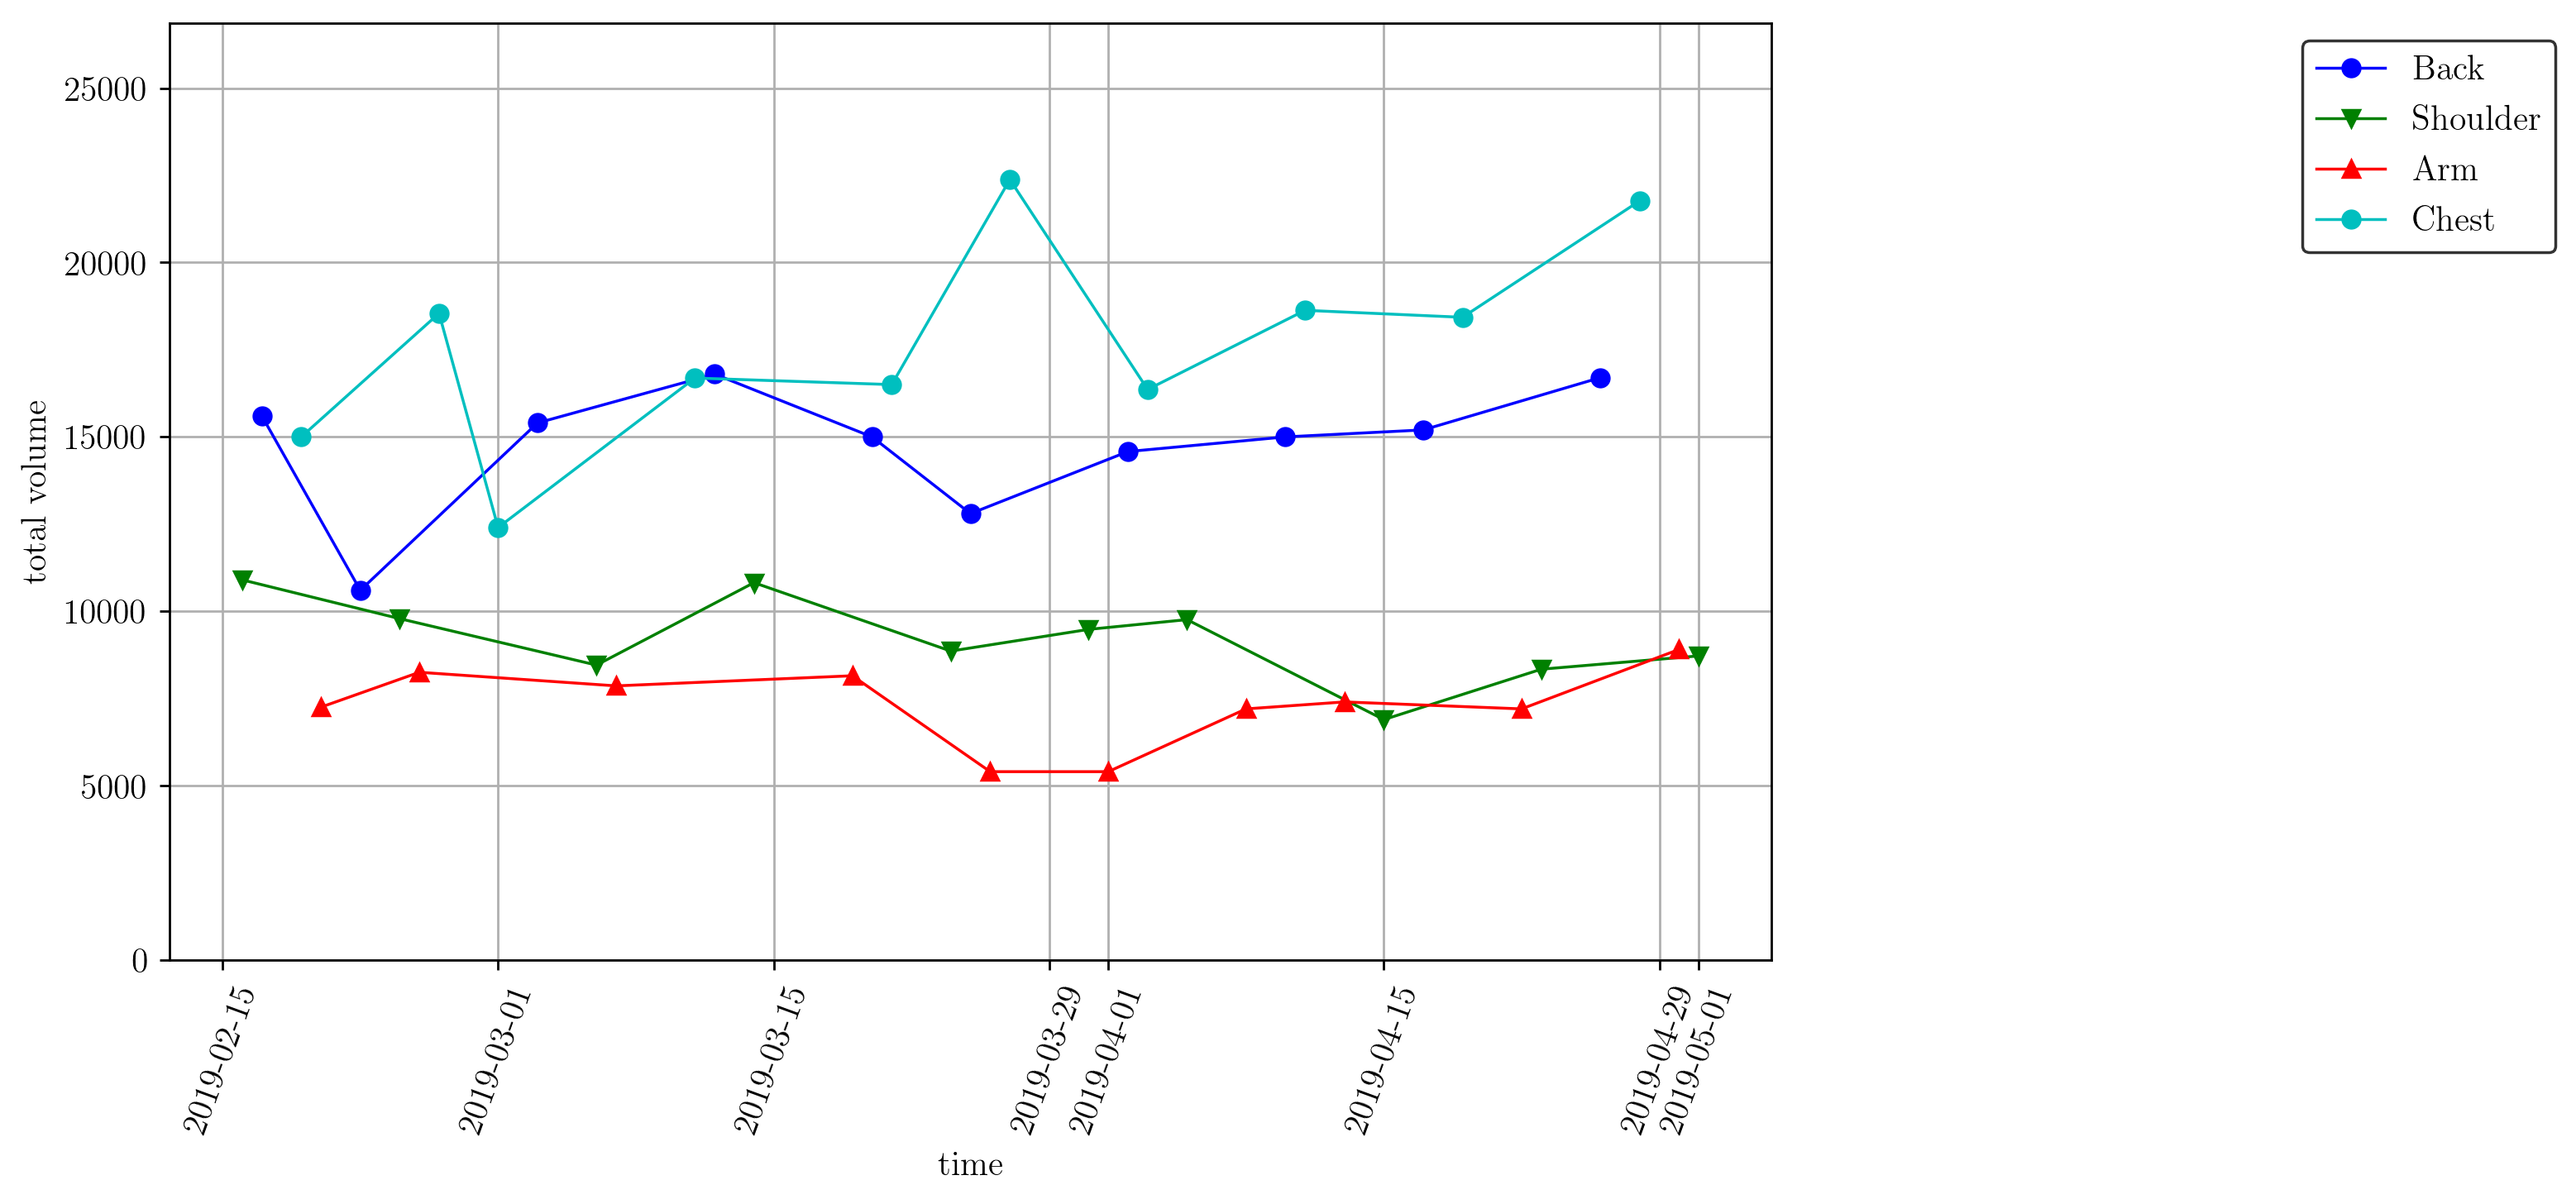

In [61]:
my_workout.plot_body(['Back', 'Shoulder', 'Arm', 'Chest'])

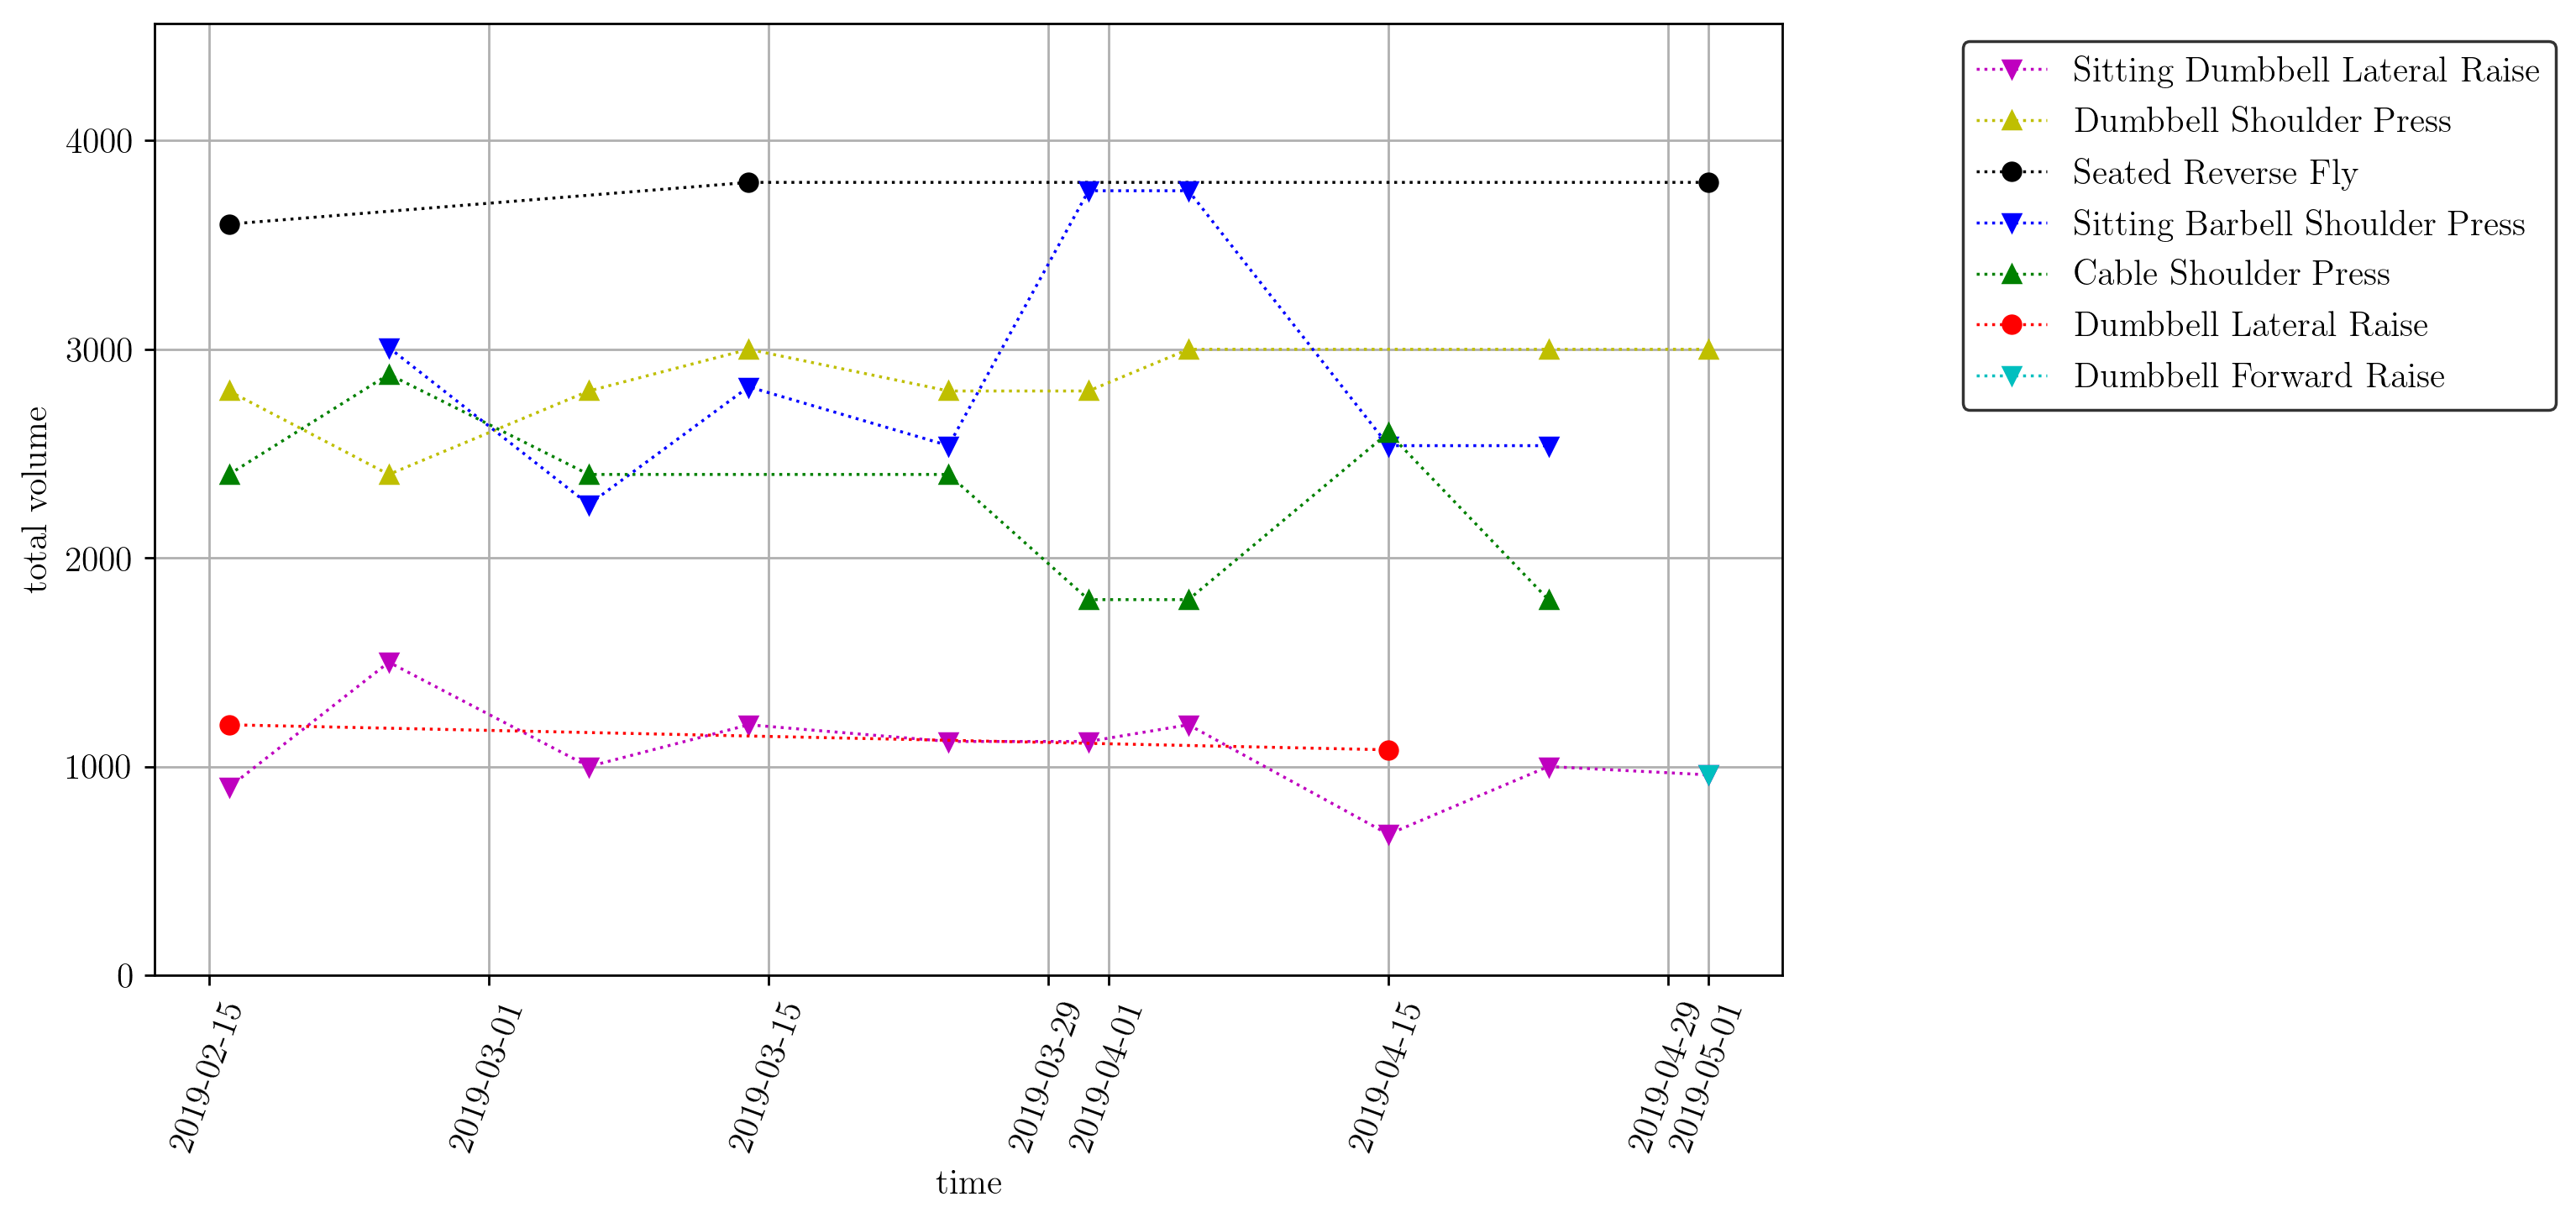

In [62]:
my_workout.plot_muscle_group('Shoulder', 'total volume')

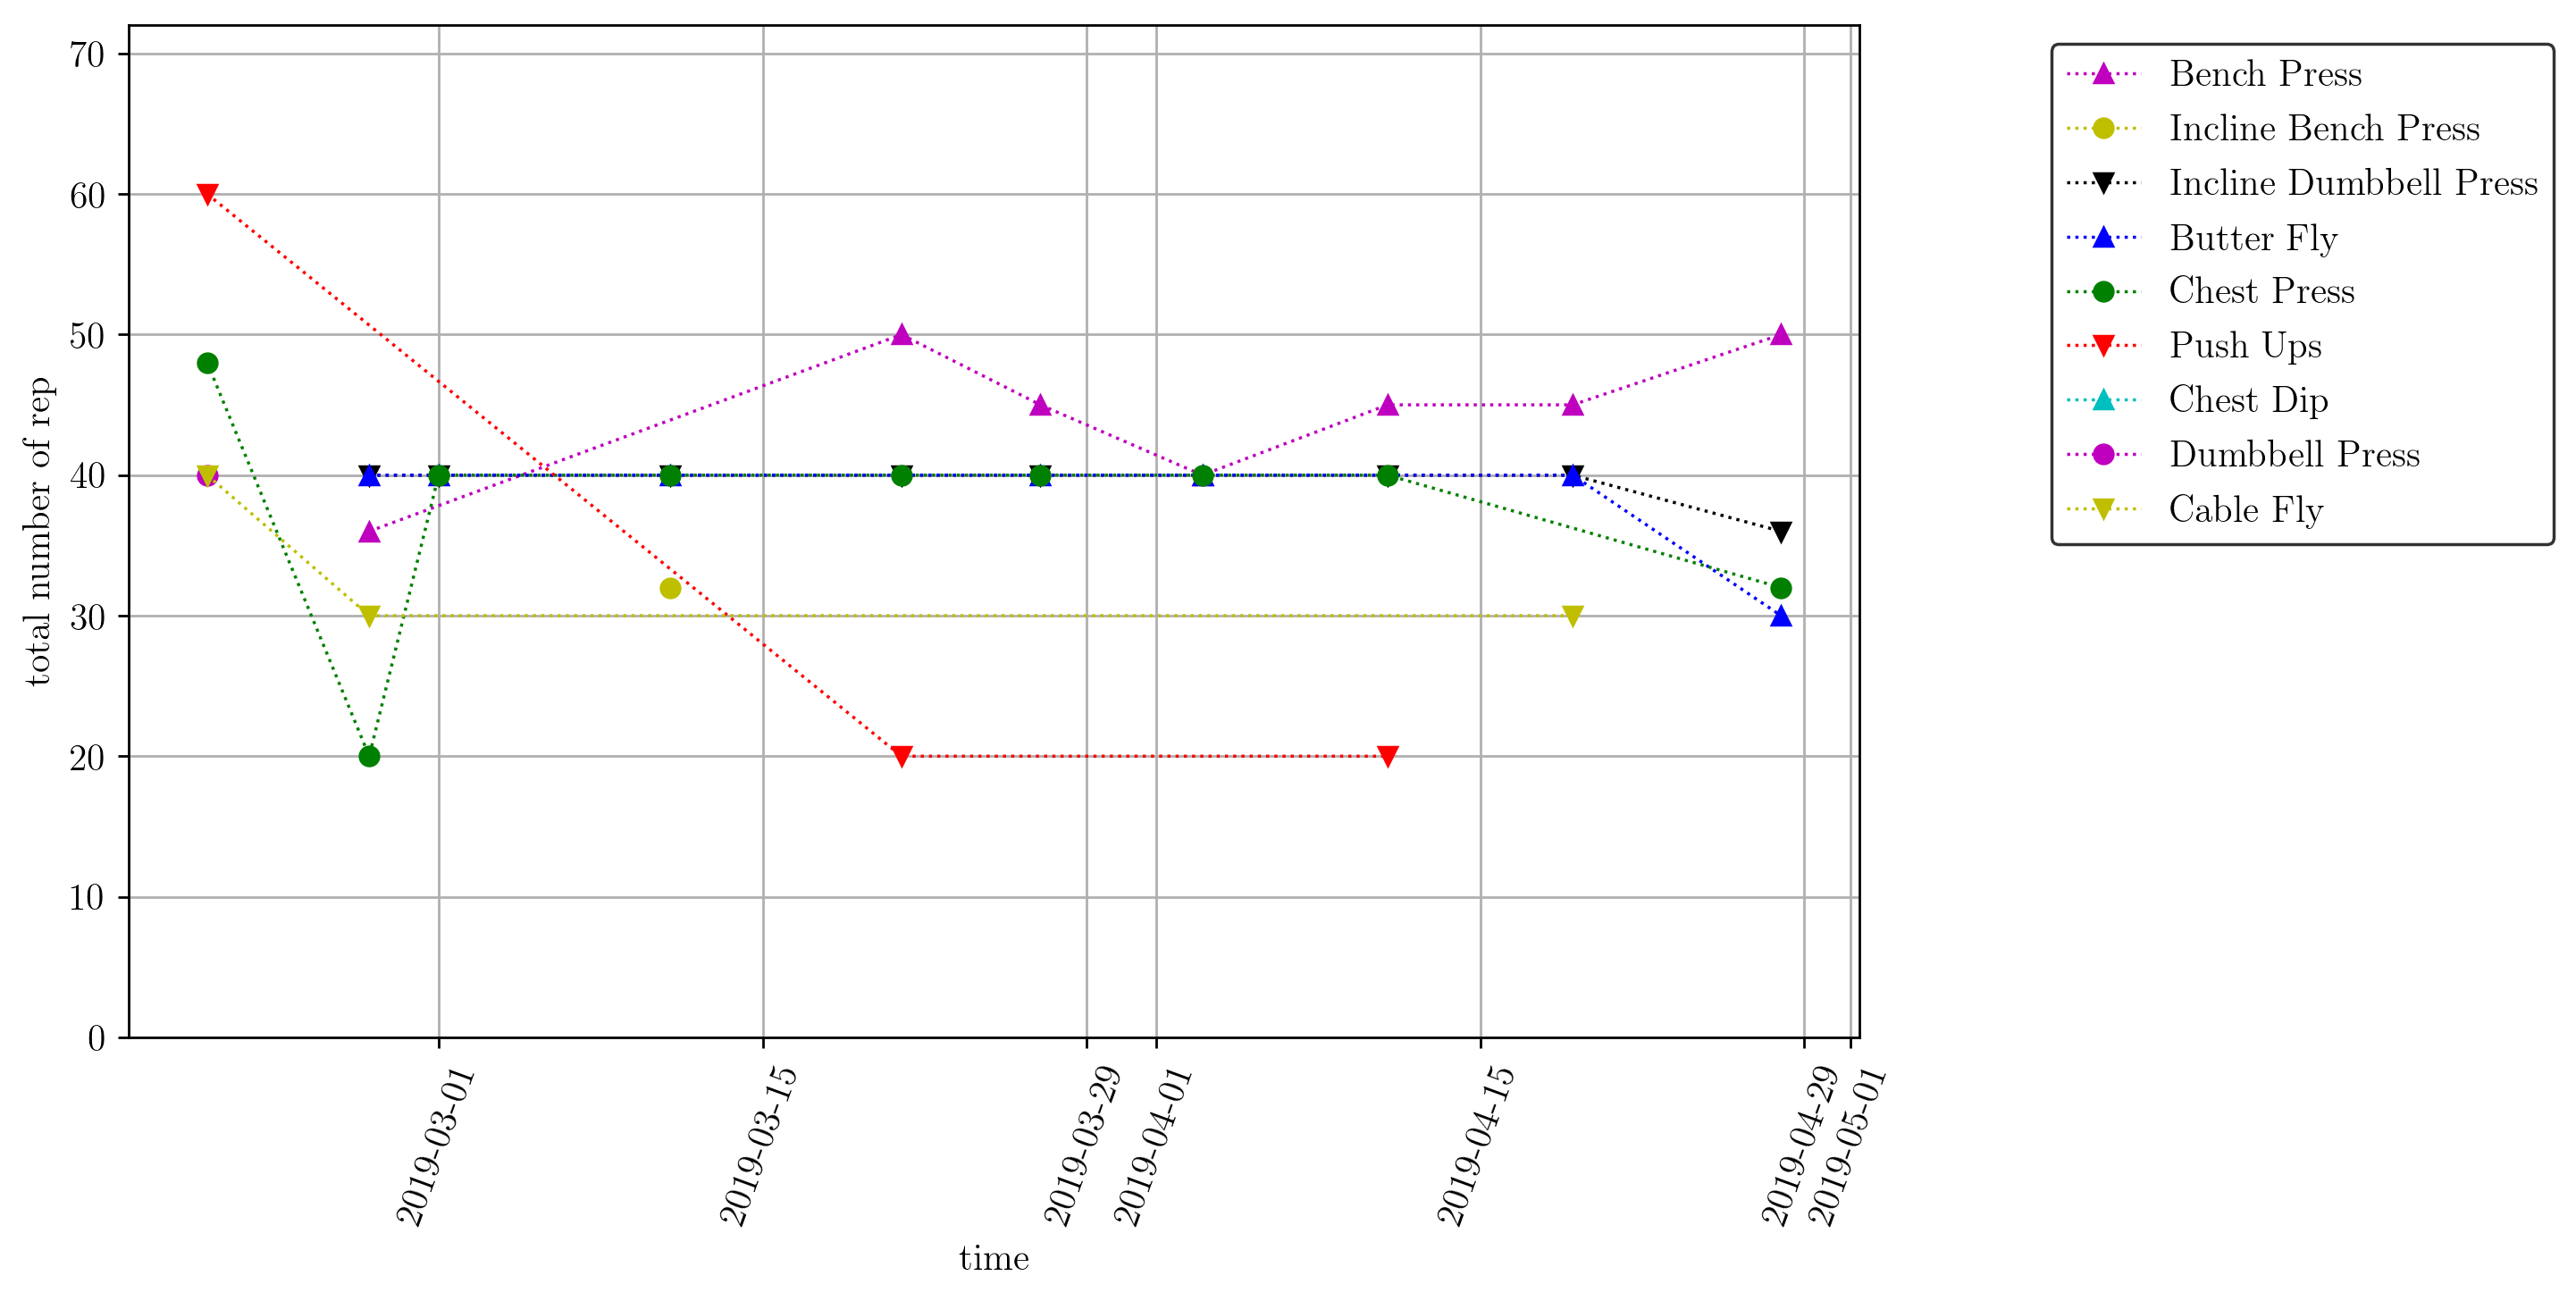

In [63]:
my_workout.plot_muscle_group('Chest', 'total number of rep')

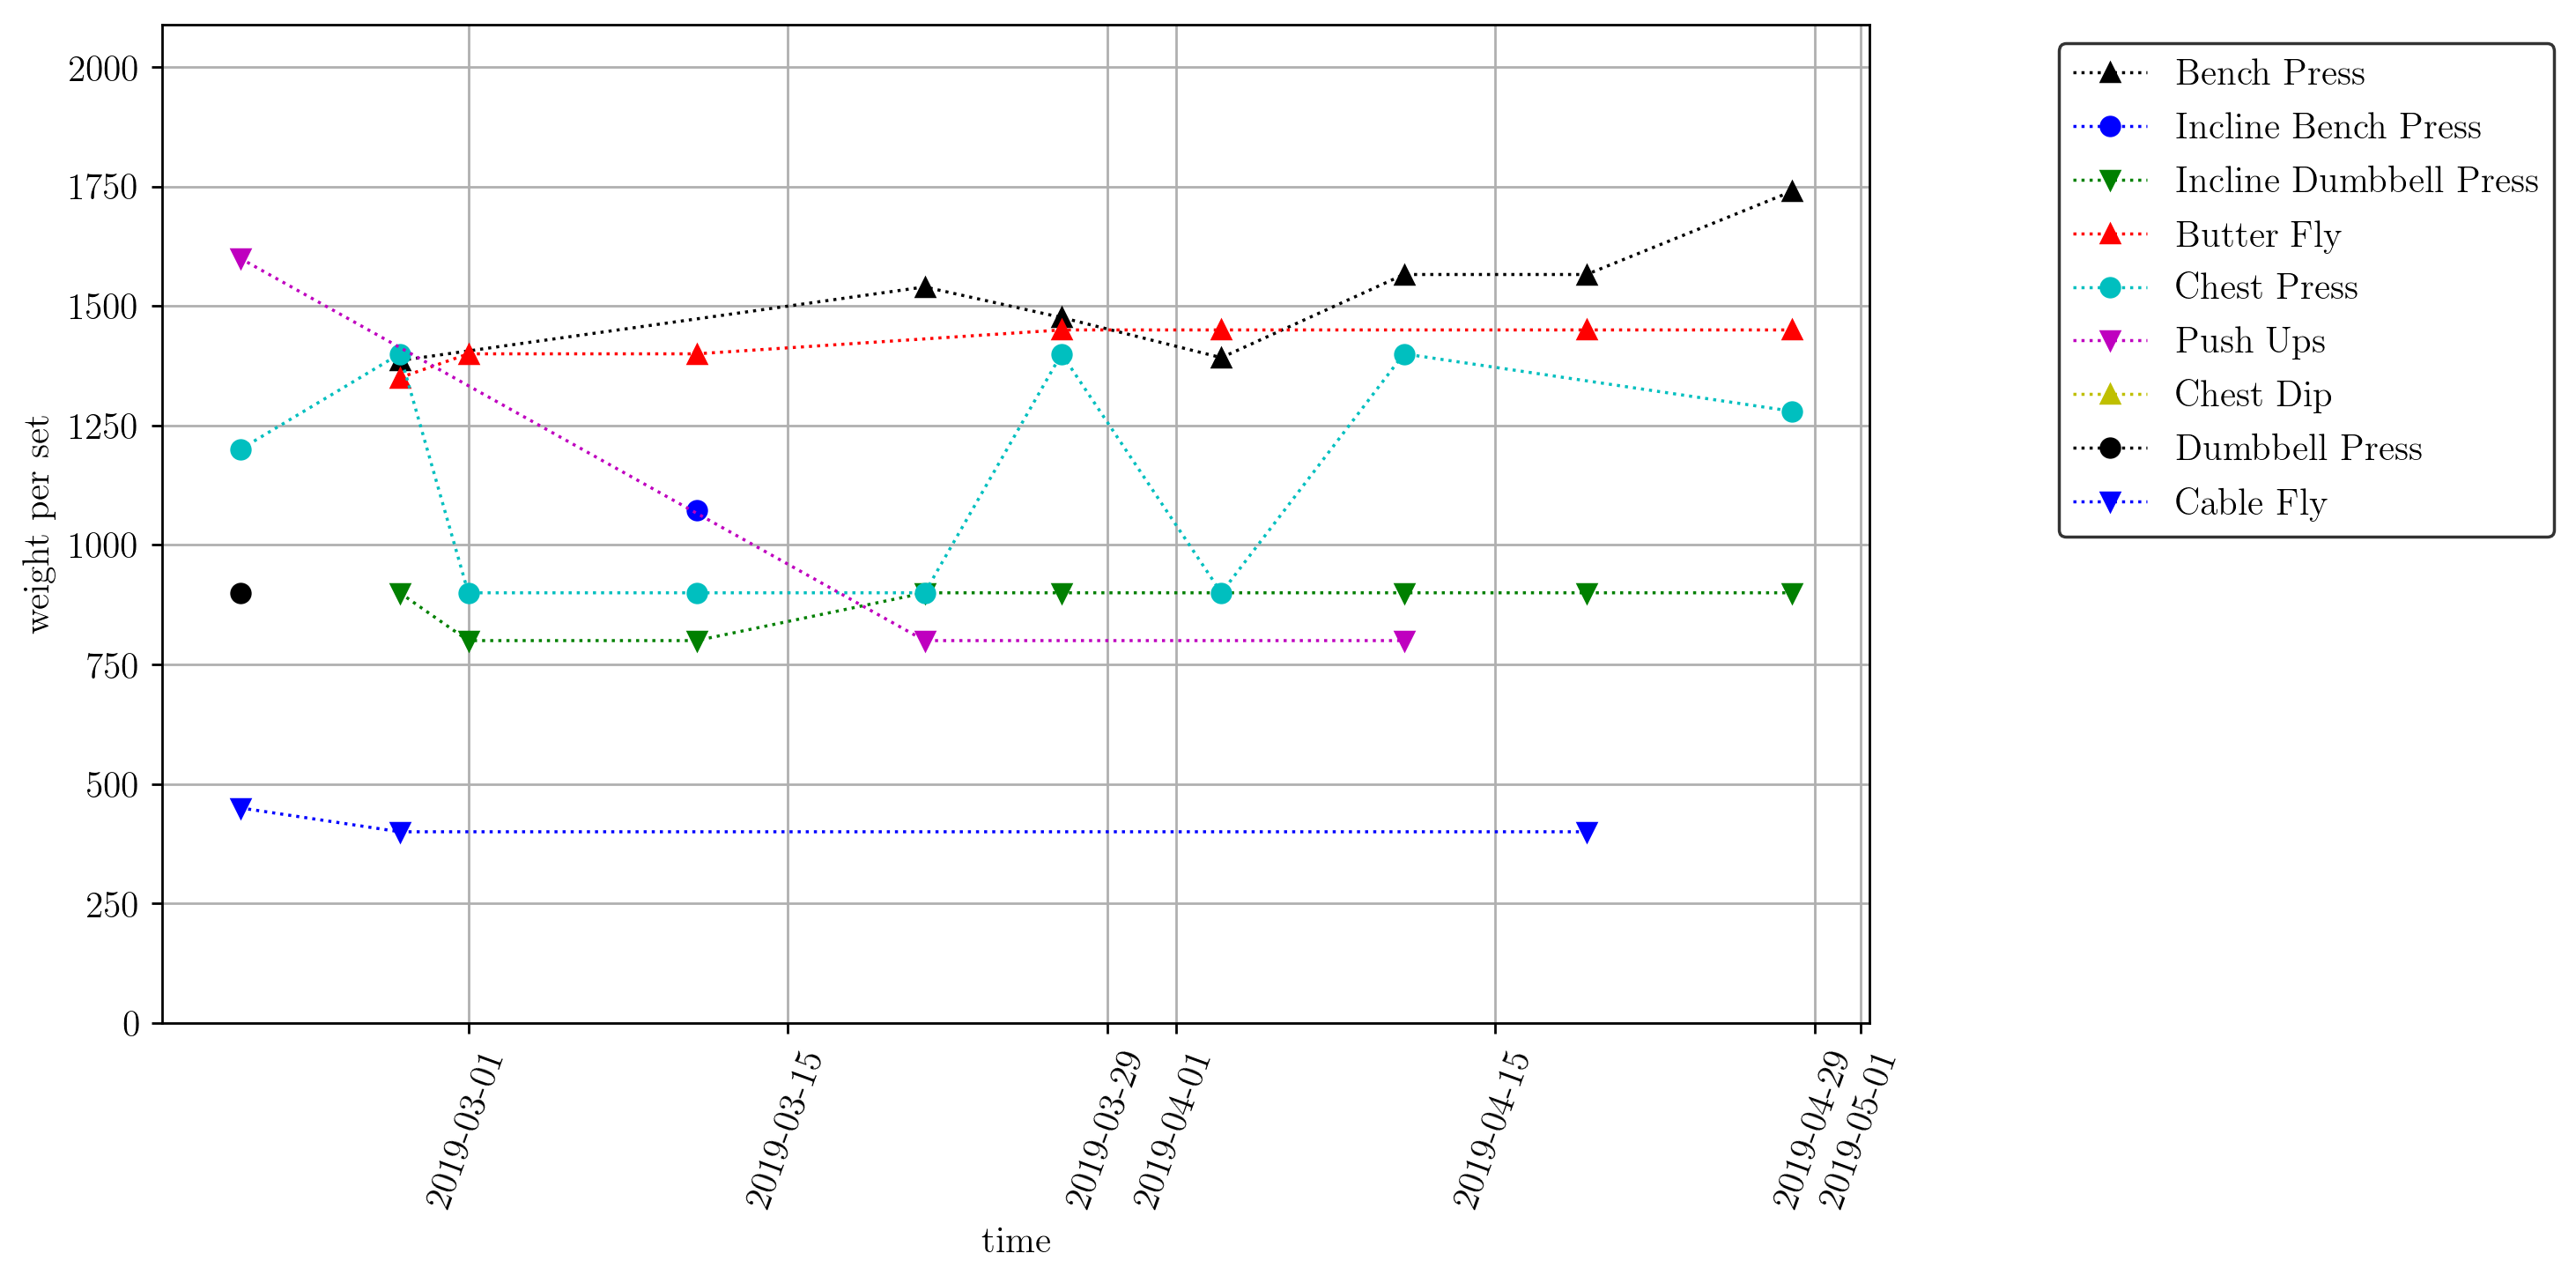

In [64]:
my_workout.plot_muscle_group('Chest', 'weight per set')